In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import time

from fastprogress import progress_bar

from scipy.linalg import qr, qr_insert

from scipy.sparse.linalg import LinearOperator

import scipy.sparse.linalg as splinalg
import scipy.sparse as sps

import pickle

import math
import shutil

#from easygsvd import gsvd as gsvd_func
#from easygsvd import random_rank_matrix


import os
import sys
sys.path.append("../..")
sys.path.append("..")
sys.path.append("../../..")

from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

from pytikhonov import ProjectedTikhonovFamily

from pytikhonov.matrices import first_order_derivative_1d



from hybridpro import HybridProjectionIRLSSolver

from hybridpro_spacetime import HybridProjectionSpaceTimeIRLSSolver, vstack_linear_operators

In [2]:
burgers_data = np.load("exact_solution.npy").T
grid_shape = burgers_data.shape

# Set up the toy problem

In [3]:
burgers_data = np.load("exact_solution.npy").T[:,:350]
grid_shape = burgers_data.shape
n_space, n_time = grid_shape
xtrue = burgers_data.flatten()
N = len(xtrue)

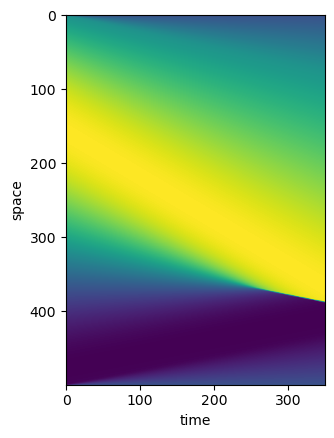

In [4]:
plt.imshow(burgers_data)
plt.xlabel("time")
plt.ylabel("space")
plt.show()

In [5]:
# Parameters
n_skip_space = 7
P1d = np.eye(burgers_data.shape[0])[::n_skip_space,:]


# Build the 2D operator

def matvec(x):
    """Compute y = A x."""
    tmp = x.reshape(grid_shape)
    tmp = P1d @ tmp
    return tmp.flatten()

def rmatvec(x):
    """Compute y = A^T x."""
    # x has shape (P1d.shape[0] * grid_shape[1],)
    tmp = x.reshape(P1d.shape[0], grid_shape[1])   # (Nx_sub, Ny)
    tmp = P1d.T @ tmp                              # (Nx_full, Ny)
    return tmp.flatten()                           # length = Nx_full * Ny


A = LinearOperator(
    shape=(P1d.shape[0]*n_time, N),
    matvec=matvec,
    rmatvec=rmatvec,
    dtype=float,
)


In [6]:
n_space, n_time = grid_shape
L1d_space, _ = first_order_derivative_1d(n_space)
L1d_time, _ = first_order_derivative_1d(n_time)
Lspace = sps.kron(L1d_space, sps.eye(n_time))
Ltime = sps.kron(sps.eye(n_space), L1d_time)
L = sps.vstack([Lspace, Ltime])

In [7]:
np.random.seed(0)
noise_sigma = 3*1e-1
noise_var = noise_sigma**2
btrue = A @ xtrue
M = len(btrue)
b = btrue + noise_sigma*np.random.normal(size=M)
backproj = (A.T @ b).reshape(grid_shape)

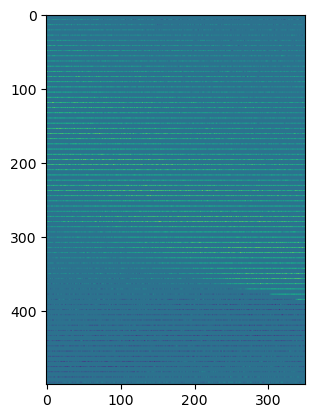

In [8]:
plt.imshow(backproj)
plt.show()

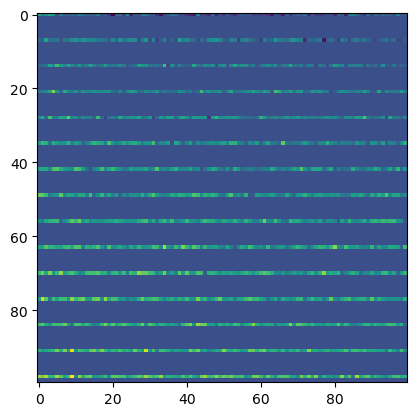

In [9]:
plt.imshow(backproj[:100,:100])
plt.show()

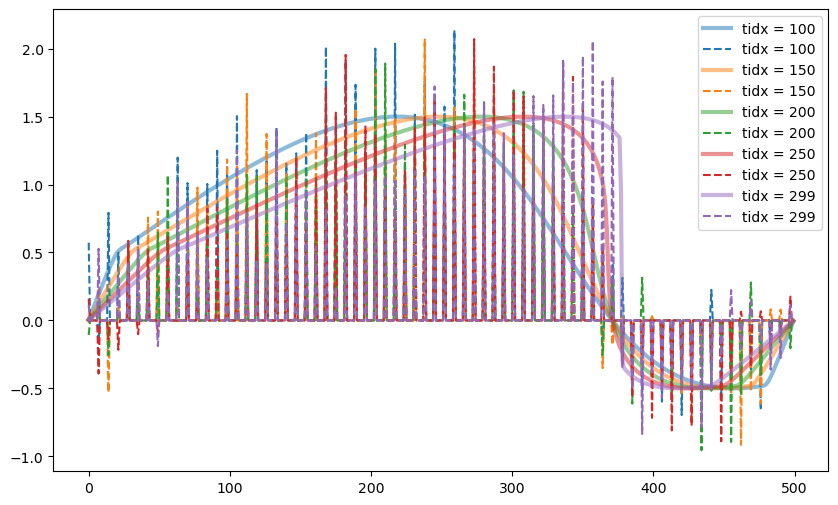

In [10]:
inspect_time_idxs = [100, 150, 200, 250, 299] # indices to inspect solution at

plt.figure(figsize=(10,6))
for j, t in enumerate(inspect_time_idxs):
    plt.plot(burgers_data[:,t], label=f"tidx = {t}", color=f"C{j}", ls="-", alpha=0.5, lw=3)
    plt.plot(backproj[:,t], label=f"tidx = {t}", color=f"C{j}", ls="--")

plt.legend()
plt.show()

# GKS with joint spatiotemporal data

In [11]:
# Solution by GKS
solver = HybridProjectionIRLSSolver(A, aslinearoperator(L), b, noise_var=noise_var)
joint_data_dp = solver.solve(n_iters=25, regparam="dp", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_dp")
joint_data_lcorner = solver.solve(n_iters=25, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_lcurve")

In [12]:
recon = joint_data_dp["x"].reshape(grid_shape)
joint_data_dp.keys()

dict_keys(['x', 'w', 'z', 'proj_basis', 'lambdah', 'rel_errs', 'lambdahs', 'V', 'AV', 'LV', 'WLV', 'x_under', 'b_under', 'd_under', 'A_matvecs', 'L_matvecs', 'completed_iterations', 'tot_calc_time', 'projected_condition_numbers', 'restarting', 'restart_dim'])

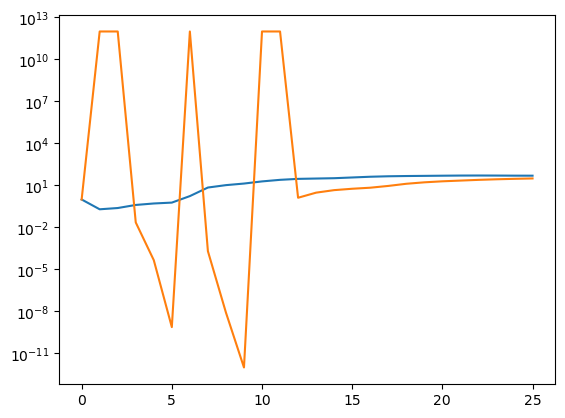

In [13]:
plt.semilogy(joint_data_dp["lambdahs"])
plt.semilogy(joint_data_lcorner["lambdahs"])
plt.show()

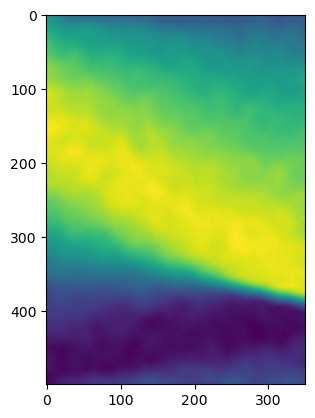

In [14]:
plt.imshow(recon)
plt.show()

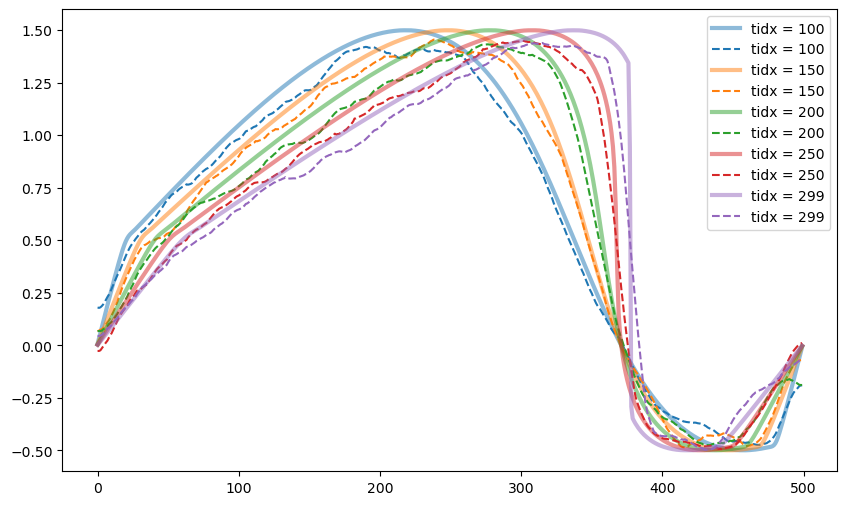

In [18]:
inspect_time_idxs = [100, 150, 200, 250, 299] # indices to inspect solution at

plt.figure(figsize=(10,6))
for j, t in enumerate(inspect_time_idxs):
    plt.plot(burgers_data[:,t], label=f"tidx = {t}", color=f"C{j}", ls="-", alpha=0.5, lw=3)
    plt.plot(recon[:,t], label=f"tidx = {t}", color=f"C{j}", ls="--")

plt.legend()
plt.show()

# Study?

In [30]:
#lambda_ts = np.logspace(start=-8, stop=8, num=16)
lambda_ts = np.logspace(start=0, stop=1.5, num=8)
# lambda_ts = np.logspace(start=-4, stop=4, num=4)
datas = []
for lambda_t in progress_bar(lambda_ts):

    # Build stacked
    Atilde = vstack_linear_operators( A, aslinearoperator( np.sqrt(lambda_t)*Ltime ) )
    btilde = np.hstack( [b, np.zeros(Ltime.shape[0])] )
    Ltilde = Lspace.copy()

    # Build solver and solve
    #solver = HybridProjectionIRLSSolver(Atilde, aslinearoperator(Ltilde), btilde, noise_var=noise_var)
    solver = HybridProjectionSpaceTimeIRLSSolver(A, aslinearoperator(Lspace), aslinearoperator(Ltime), b, noise_var=noise_var)
    
    # Collect results
    data = solver.solve(lambda_t, n_iters=25, regparam="dp", xtrue=xtrue, x0=None, gen_plots=False, out_dir="results")
    #joint_data_lcorner = solver.solve(n_iters=25, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_lcurve")
    datas.append( (data, data["lambdah"], lambda_t) )

0.15827321908562877
0.30462134160693555
0.3492983845335828
0.45029032526903684
0.5608378082855937
1.6078552147630187
10.908527163427914
22.477506256957405
32.36031212370824
41.618834737274206
50.230087510237205
57.43157332551826
63.518496092526604
68.77339298230275
73.51453995131457
77.68052441040533
81.30117181640016
84.03932623067219
86.0573204296448
87.25153661017548
87.98091758751353
88.43897398559712
88.72493508802742
88.83939994165301
88.70759494756336


0.14261158929054224
0.2668025508778956
0.29484654929045667
0.3535947141104216
0.4218893347692585
0.49525010195432806
0.8837824825609596
5.668636126138447
18.462301752523672
29.034472729725383
38.534001489547585
46.922598295382116
53.71547732742311
59.57104657646672
64.005021180001
68.12983814488014
71.6716567301193
74.83683423617727
77.35723453545995
78.98932936088147
80.08947434642569
80.34138869445621
80.49053497234469
80.34270720435276
80.16438100138393


0.12718665724834655
0.1792609193685876
0.23894477818581003
0.26551465940518365
0.29490263550219337
0.3453043422026711
0.3954417861874021
0.44433116410374485
0.5833773772538096
2.291980539327697
13.92575887823476
24.98006937917384
35.17735612888697
43.90070667994765
50.59324481707409
55.59035226226105
60.00787087431911
63.08844657059636
65.92008091279483
68.5435414660196
70.58508916882079
72.0431881275593
72.760534373939
73.06539481447922
72.66912610707463


0.11299686605123624
0.11629242570059453
0.1385488768224009
0.18699425771709013
0.21991105294635713
0.2400828316486695
0.2593427973565404
0.2870810641216742
0.32638658675558413
0.3622799387841406
0.39388916272942837
0.44268113207054927
0.6446038030127993
3.2223794293321286
17.190759300116014
27.210436676396387
37.293199676305015
44.764229479621804
50.09890577812014
53.943463441199775
57.17985552235
59.64755430869493
61.555540528911806
63.46963335387914
64.92926548725463


0.10052838802834692
0.10007366560632153
0.10044780014885257
0.1044462873915776
0.1216158814861406
0.15487791036957912
0.18404405412653804
0.2029683876641265
0.21660923046510805
0.22926547005796563
0.24503652154651706
0.2684443683963911
0.29648947803335923
0.32133436350020506
0.34228523659830623
0.36414869136569444
0.39951946423495777
0.5099097725078978
1.4332007119034444
8.541612894165118
23.075983803448405
31.622271529883797
40.39083127218122
46.12754418165695
49.64574206917192


0.08957455388797687
0.08906819585257565
0.08840648856696263
0.08775942602455904
0.08740546183037967
0.08853269491792329
0.09464923790164817
0.1113218643970952
0.13612859802899013
0.1576104049266893
0.17262500509263137
0.18362695242942426
0.19265292029232253
0.2009428013817942
0.20981248497862953
0.2212678000072519
0.23743106581056891
0.25671716439640374
0.27500378768192657
0.29052541731028697
0.30344447689092713
0.3159482994222954
0.33051858006249946
0.35495838705864013
0.42350396070430174


0.07920895694587274
0.07953523533162328
0.07909764560788612
0.07846357013536145
0.07774117971697825
0.07698668714987464
0.07628217065880209
0.07586619352615602
0.07637759965171548
0.07924587585720759
0.08680412512118005
0.10067955315587106
0.11806839611292912
0.13380789312250643
0.14602205539548807
0.15520572505949656
0.16241769555844573
0.16846972374636965
0.17375173345178227
0.17885826914902664
0.18418572034756966
0.19077290617222428
0.1998072731304226
0.21162783930805332
0.22526998606582518


0.06782951180590314
0.07034720591996678
0.07074492612804802
0.07046121557319832
0.06994814032343157
0.06937080124211242
0.06877226568006307
0.06814461364834336
0.06746179511786218
0.06669454414767256
0.06589328567291464
0.06525283620755434
0.06513318166066513
0.0661718658795949
0.06935151099969328
0.07578901571183908
0.08591520789840848
0.09834423053290857
0.11021159044301725
0.12044253065516602
0.12866567734731965
0.13512264616009617
0.14031252005687173
0.14458391841619397
0.14834706280103918


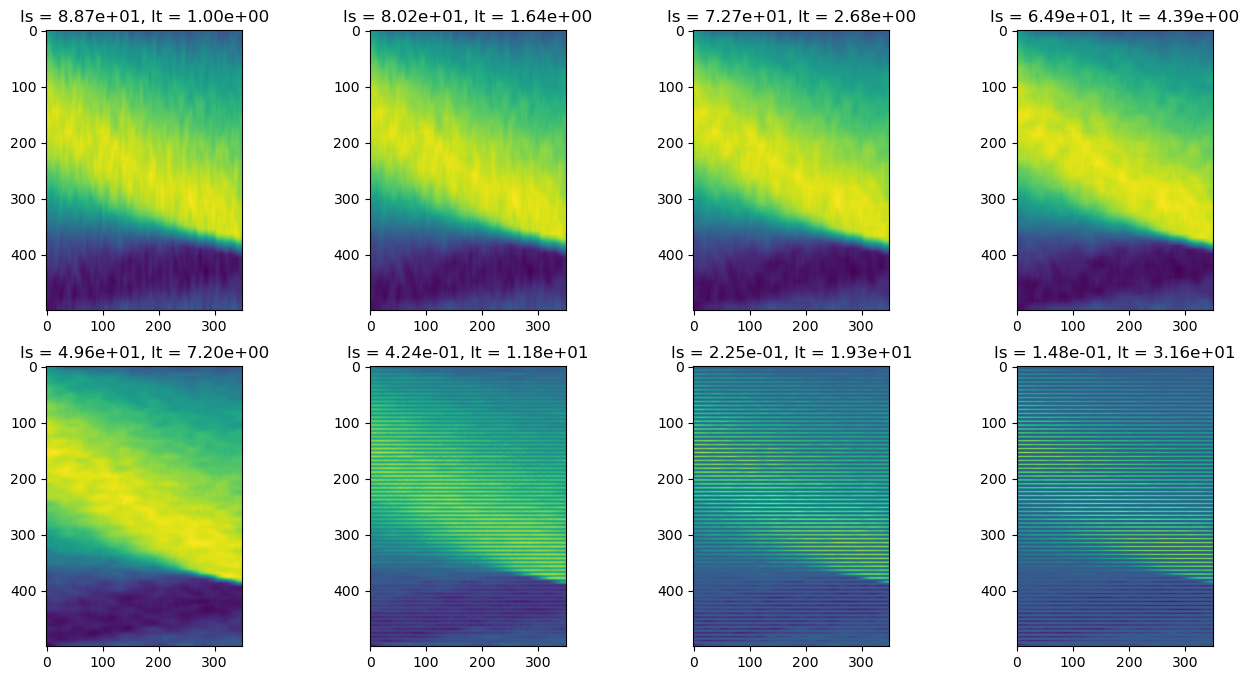

In [32]:
fig, axs = plt.subplots(2,4,figsize=(16,8))

for i, ax in enumerate(axs.ravel()):

    ax.imshow(datas[i][0]["x"].reshape(grid_shape))
    ax.set_title(f"ls = {datas[i][1]:.2e}, lt = {datas[i][2]:.2e}")

plt.show()

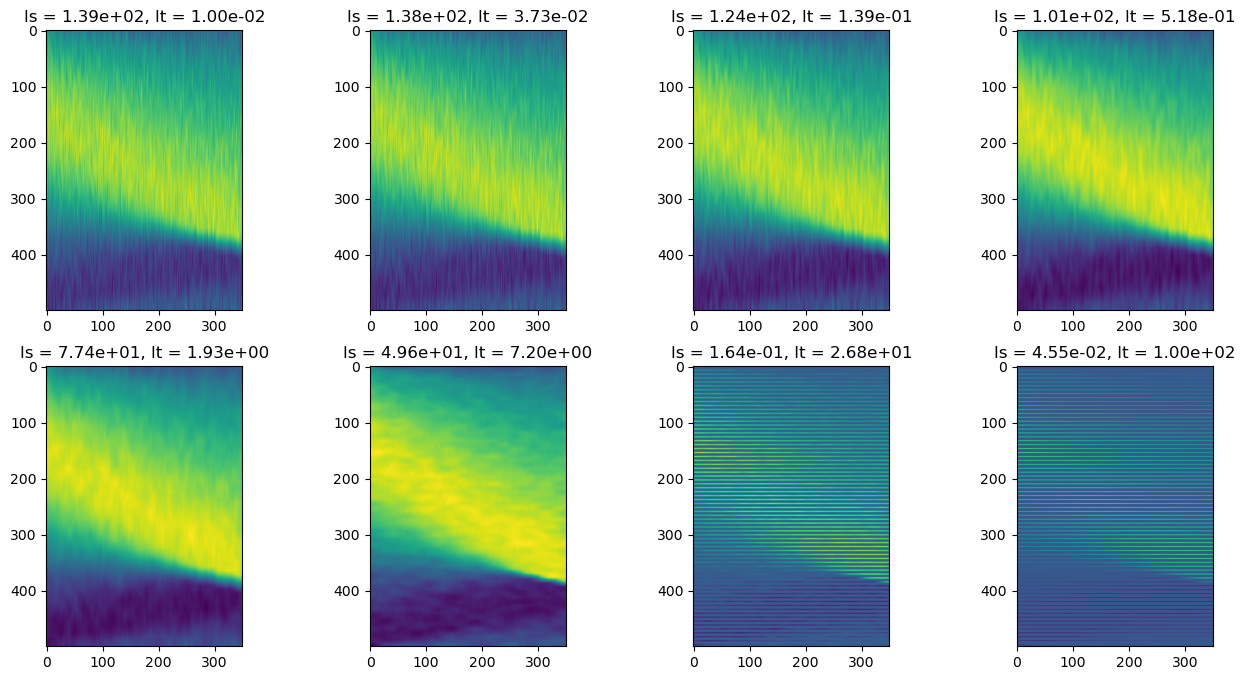

In [17]:
fig, axs = plt.subplots(2,4,figsize=(16,8))

for i, ax in enumerate(axs.ravel()):

    ax.imshow(datas[i][0]["x"].reshape(grid_shape))
    ax.set_title(f"ls = {datas[i][1]:.2e}, lt = {datas[i][2]:.2e}")

plt.show()

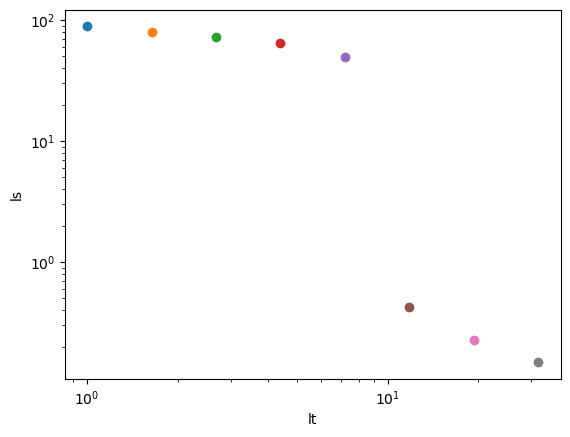

In [33]:
for i in range(8):
    plt.scatter([datas[i][2]], [datas[i][1]])

plt.xlabel("lt")
plt.ylabel("ls")
plt.xscale("log")
plt.yscale("log")

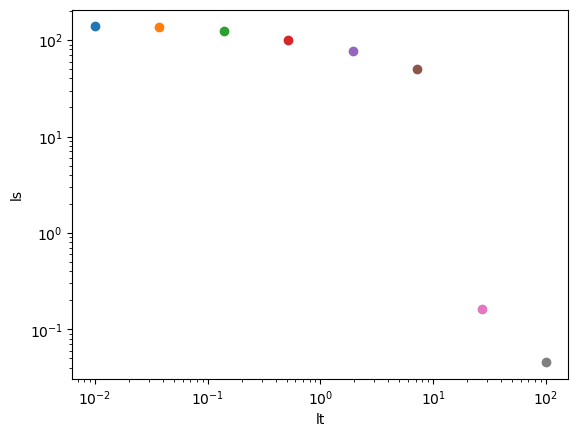

In [27]:
for i in range(8):
    plt.scatter([datas[i][2]], [datas[i][1]])

plt.xlabel("lt")
plt.ylabel("ls")
plt.xscale("log")
plt.yscale("log")

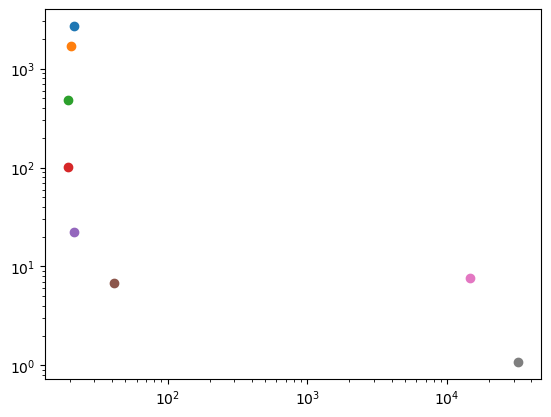

In [22]:
for i in range(8):

    x = datas[i][0]["x"]
    lspacenorm = np.linalg.norm(Lspace @ x)**2
    ltimenorm = np.linalg.norm(Ltime @ x)**2

    plt.scatter([lspacenorm], [ltimenorm])

plt.xscale("log")
plt.yscale("log")

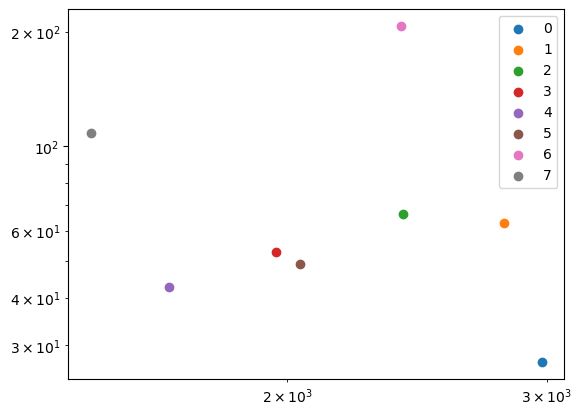

In [23]:
for i in range(8):

    x = datas[i][0]["x"]
    lspacenorm = datas[i][1]*np.linalg.norm(Lspace @ x)**2
    ltimenorm = datas[i][2]*np.linalg.norm(Ltime @ x)**2

    plt.scatter([lspacenorm], [ltimenorm], label=f"{i}")

plt.xscale("log")
plt.yscale("log")
plt.legend()

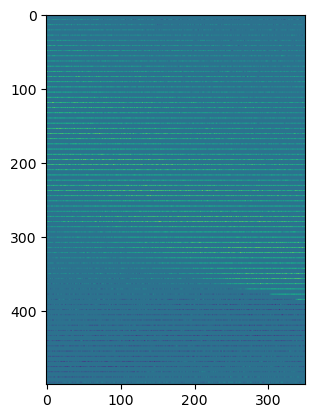

In [20]:
plt.imshow( joint_data_dp["V"][:,0].reshape(grid_shape) )
plt.show()

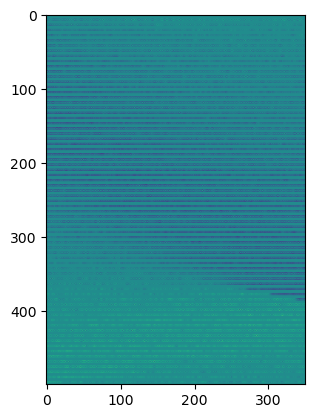

In [21]:
plt.imshow( joint_data_dp["V"][:,1].reshape(grid_shape) )
plt.show()

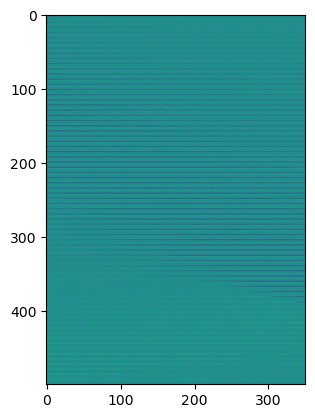

In [38]:
plt.imshow( joint_data_dp["V"][:,5].reshape(grid_shape) )
plt.show()

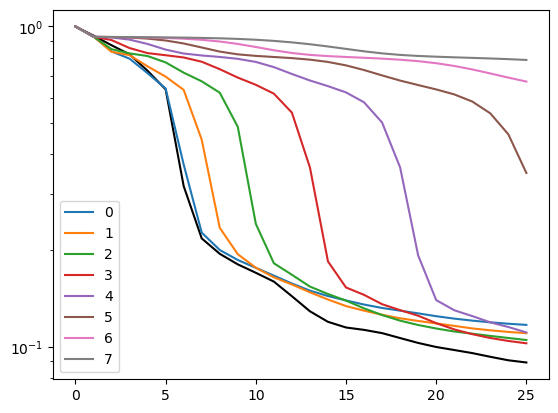

In [34]:
plt.semilogy(joint_data_dp["rel_errs"], color="k")
for i in range(8):
    plt.semilogy( datas[i][0]["rel_errs"], label=f"{i}")

plt.legend()
plt.show()

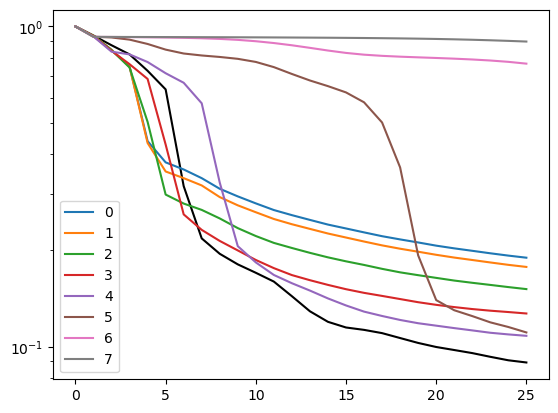

In [28]:
plt.semilogy(joint_data_dp["rel_errs"], color="k")
for i in range(8):
    plt.semilogy( datas[i][0]["rel_errs"], label=f"{i}")

plt.legend()
plt.show()

In [29]:
datas[5][2]

np.float64(7.196856730011514)

In [ ]:
#lambda_t = joint_data_dp["lambdah"]/100
lambda_t = datas[5][2]

# Build stacked
Atilde = vstack_linear_operators( A, aslinearoperator( np.sqrt(lambda_t)*Ltime ) )
btilde = np.hstack( [b, np.zeros(Ltime.shape[0])] )
Ltilde = Lspace.copy()

# Build solver and solve
#solver = HybridProjectionIRLSSolver(Atilde, aslinearoperator(Ltilde), btilde, )
solver = HybridProjectionSpaceTimeIRLSSolver(A, aslinearoperator(Lspace), aslinearoperator(Ltime), b, noise_var=noise_var)
    
# Collect results
data = solver.solve(lambda_t, n_iters=25, regparam="dp", xtrue=xtrue, x0=None, gen_plots=False, out_dir="results")

# Collect results
# data = solver.solve(n_iters=25, regparam="dp", xtrue=xtrue, x0=None, gen_plots=False, out_dir="results")
#joint_data_lcorner = solver.solve(n_iters=25, regparam="lcorner", xtrue=xtrue, x0=None, gen_plots=False, out_dir="joint_spatiotemporal_lcurve")
# datas.append( (data, data["lambdah"], lambda_t) )

0.08957455388797687
0.08906819585257565
0.08840648856696263
0.08775942602455904
0.08740546183037967
0.08853269491792329
0.09464923790164817
0.1113218643970952
0.13612859802899013
0.1576104049266893
0.17262500509263137
0.18362695242942426
0.19265292029232253
0.2009428013817942
0.20981248497862953
0.2212678000072519
0.23743106581056891
0.25671716439640374
0.27500378768192657
0.29052541731028697
0.30344447689092713
0.3159482994222954
0.33051858006249946
0.35495838705864013
0.42350396070430174


TypeError: solve() missing 1 required positional argument: 'lambdah_t'

0.5007458396721991
4582.959043237509


C:\Users\Jon\AppData\Local\Temp\ipykernel_39992\2009739298.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


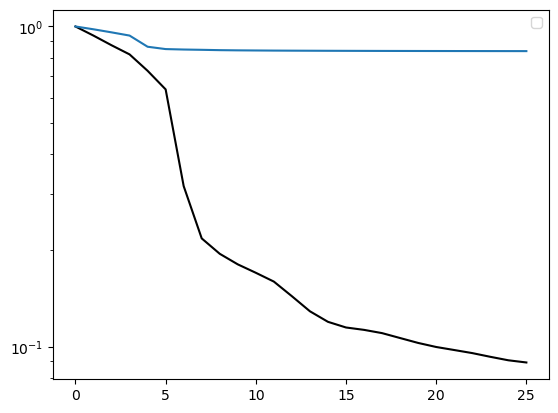

In [76]:
print(lambda_t)
print(data["lambdah"])

plt.semilogy(joint_data_dp["rel_errs"], color="k")

plt.semilogy(data["rel_errs"])

plt.legend()
plt.show()

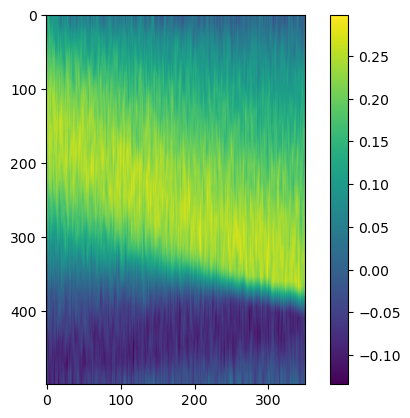

In [77]:
plt.imshow(data["x"].reshape(grid_shape))
plt.colorbar()

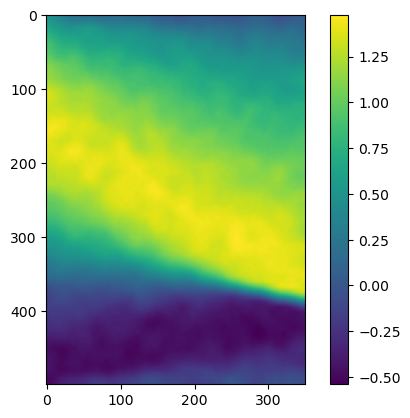

In [62]:
plt.imshow(joint_data_dp["x"].reshape(grid_shape))
plt.colorbar()

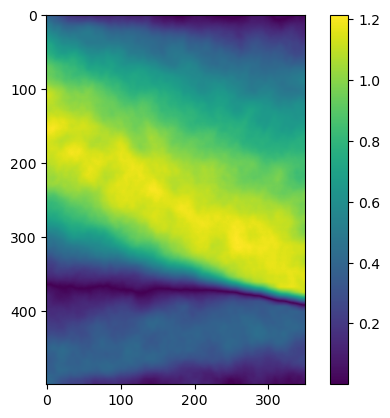

In [61]:
plt.imshow(np.abs( joint_data_dp["x"].reshape(grid_shape) - data["x"].reshape(grid_shape) ) )
plt.colorbar()

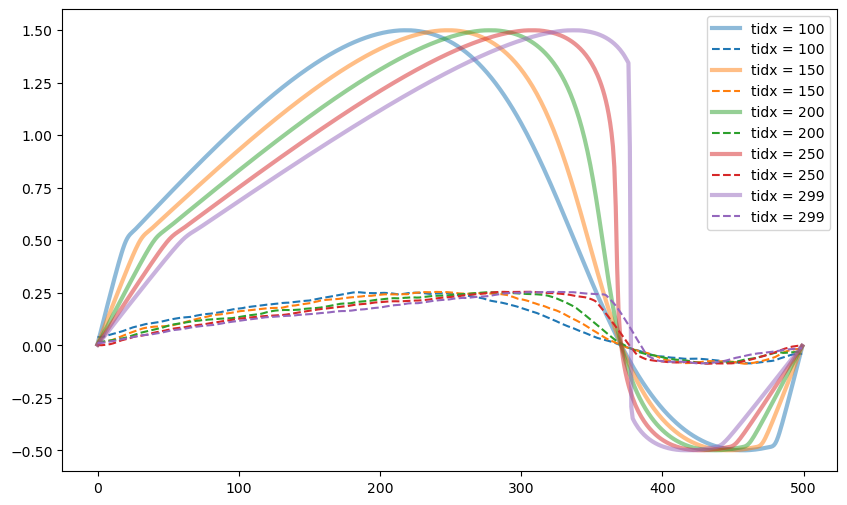

In [64]:
inspect_time_idxs = [100, 150, 200, 250, 299] # indices to inspect solution at

plt.figure(figsize=(10,6))
for j, t in enumerate(inspect_time_idxs):
    plt.plot(burgers_data[:,t], label=f"tidx = {t}", color=f"C{j}", ls="-", alpha=0.5, lw=3)
    plt.plot(data["x"].reshape(grid_shape)[:,t], label=f"tidx = {t}", color=f"C{j}", ls="--")

plt.legend()
plt.show()